# Advanced Statistical Methods for Data Intensive Science (Lent Term Project)

### Overview

In 1901 Captain Dimitrios Kontos and a crew of sponge divers, retrived numerous large objects from an ancient Roman cargo ship, 45 meters below the sea level, near the island of Antikythera (Greek island located in the Mediterranean Sea). Among the many objects retrived from the wreckage there was a tool, that is now know as the Antikythera mechanism.

The mechanism was designed by ancient Greek astronomers during the second century BC. This was the first known analog computer in human history. This consists of a ca;emdar ring with holes punched at the extrimity of its circumference. Unfortunaly approximatelly $25\%$ of the ring survived. We used to believe that the full ring contained $365$ holes, impling that the mechanism was used as a solar calendar. While, a new theory suggest that there were $354$ holes overall, i.e. the mechanism was a lunar calendar.

### Project Objective

In this project we aim to use an X-ray image of the calendar ring to then infer on the number of holes present in the comple ring, through Bayesian inference with Hamiltonian Monte Carlo. 


In [ ]:
# Importing required packages
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import jax.numpy as jnp
from jax import grad, jit, vmap
from iminuit import Minuit 
from src.model import*
from src.originial_model import*
from src.plotting import*
from numpyro.infer import NUTS, MCMC, Predictive
import jax
import corner
from dynesty import NestedSampler
from numpyro.infer.util import log_likelihood
from numpyro import handlers
from scipy.optimize import approx_fprime

/root/Document/Term2/S2/S2_Cw/s2_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Visualising Data

In [2]:
# Importing data on Antikythera Mechanism (AM) as data_AM
data_AM = pd.read_csv("data/1-Fragment_C_Hole_Measurements.csv")

# Printing data
data_AM  

,Section ID,Hole,Inter-hole Distance,Mean(X),Mean(Y)
0,0,1,NaN,15.59931,92.59653
1,1,2,NaN,16.44167,91.50069
2,1,3,1.440694,17.30764,90.34931
3,1,4,1.456973,18.15278,89.16250
4,1,5,1.299821,18.96528,88.14792
...,...,...,...,...,...
76,7,77,1.259985,108.69444,63.42778
77,7,78,1.430105,110.05486,63.86875
78,7,79,1.179606,111.14583,64.31736
79,7,80,1.428043,112.48021,64.82604


As part of the first task, we want to make a plot of the measured holes $d_i \in \mathbb{R}^2$ in the $x$-$y$ plane, where $i$ labels the holes, to indicate which holes are in each fractured section of the ring. 

In [3]:
# Separating each hole based on their IDs

# Checking what is the maximum value of the Section ID 
print('Maximum value in Section ID:',max(data_AM['Section ID']))

# Max = 7, i.e. 8 sections


Maximum value in Section ID: 7


As we can see the are eight different sections of the Antikythera, let us separate each hole based on each respective section.

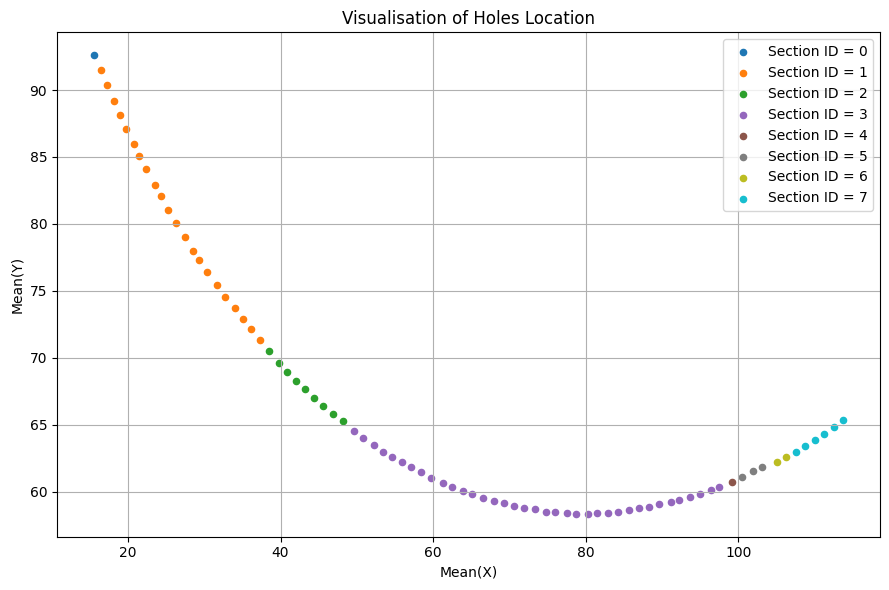

In [4]:
visualise_data(data_AM)

From section 2 of Ref [[2](https://github.com/MatteoMancini01/S2_Cw/blob/main/relevant_material/2403.00040v1.pdf)] we can breakdown the model for parts (b) and (c) of the project!

### Part (b)

The aim of this section is to code up a model for the hole locations, when considering the following assumptions:

- The original calendar ring had $N$ holes, arranged in regular pattern around a circle of radius $r$.
- Since the remaining the ring fragments are misaligned, the broken sections are allowed to be translated and rotated around the $x$-$y$ plane.
- All the parts of the ring remain within this plane.

Thus, the parameters of the model include:
- The ring radius $r$.
- The total number of holes in the orignial ring $N$.
- A set of transformation parameters (translations and rotations) for each section of the fractured ring.


<b>Theoretical Hole Location</b>

- The expected angular position of each hole $i$ in section $j$:
   $$
   \phi_{ij} = 2\pi \frac{(i-1)}{N} + \alpha_j
   $$
   where $\alpha_j$ is tha angular position of the first hole in the full circle.

- The corresponding Cartesian coordinates are:
   $$
   x_{ij} = r\cos{(\phi_{ij})} + x_{0j}
   $$
   $$
   y_{ij} = r\sin{(\phi_{ij})} + y_{0j}
   $$

- Adjust for section misaligment using the parameters ($x_{0j}, y_{0j}, \alpha_j$) 

### Part (c)

The aim of this section is to code up the likelihood function for our model. In particular we are going to implement the following Gaussian likelihood function for the hole locations under the assumption that the errors in the placement of different holes are independent. The likelihood is given by:

$$
\mathcal{L}(D|\vec{\theta}) = \frac{exp(-\frac{1}{2}[\vec{d}_i - \vec{m}_i]^{\text{T}}\cdot \Sigma^{-1}\cdot [\vec{d}_i - \vec{m}_i])}{2\phi \sqrt{|\Sigma|}}
$$

Where:
- $D$ is the data set of measured hole locations.
- $\vec{\theta}$ is the set of model parameters.
- $\vec{d}_i$ represents the measured location of the hole $i$.
- $\vec{m}_i$ represents the model-prediction location of the hole $i$.
- $\Sigma$ is the coveriance matrix, which describes the uncartainty in the hole placement.

Furtheremore, we are asked to code up two different models for the coveriance matrix $\Sigma$:
1. <b>Isotropic Gaussian model</b>, the same standard deviation "$\sigma$" applies in all directions.
2. <b>Radial-tangential model</b>, this model uses two different errors, radial $\sigma_r$ and tangential $\sigma_t$.


### Part (d)

`model.py` file will be later used for part (f). Here there are three different functions each designed for a different purpose. What we are interested in is to extract the log-likelihood function from `rad_tang_model` and `isotropic_model`. These functions have been designed to run HMC algorithm using `numpyro` libraries. For both functions the log-likelihood is not explicitly defined, and for the purposes of this part, i.e. showing differentiability for each likelihood respective models, we are going to “extract” the log-likelihoods from each models and compute few derivatives to show differentiability. 

To fulfil our objective, we are going to use `numpyro.hadlers`, to run the model and extract the log-likelihoods at a given parameter point.


Preparing data, and albitrary parameters values

In [37]:
# Importing data on Antikythera Mechanism (AM) as data_AM
data_AM = pd.read_csv("data/1-Fragment_C_Hole_Measurements.csv")
sub_data = data_AM[~data_AM['Section ID'].isin([0,4])] # removing sections 0 and 4
hole_d, x_d, y_d = jnp.array(sub_data['Hole'].to_numpy()), jnp.array(sub_data['Mean(X)'].to_numpy()), jnp.array(sub_data['Mean(Y)'].to_numpy())

sec_id_sub = sub_data['Section ID'].to_numpy()
sec_mod = jnp.array([x-1 if x < 4 else x - 2 for x in sec_id_sub]) 

data = []
for j in range(n_sec):
    indices = (sec_mod == j)
    data.append((x_d[indices], y_d[indices]))

# Setting arrays of parameters to differentiate and compare the likelihoods
theta_init_rt = jnp.array([80.0, 0.5, 0.5, -2.0, -3.0, -2.0, -1.0, 0.0, -2.0, 86.0, 78.0, 89.0, 90.0, 79.0, 74.0, 140.0, 150.0, 145.0, 148.0, 149.0, 151.0])

theta_init_is = jnp.array([80.0, 0.5, -2.0, -3.0, -2.0, -1.0, 0.0, -2.0, 86.0, 78.0, 89.0, 90.0, 79.0, 74.0, 140.0, 150.0, 145.0, 148.0, 149.0, 151.0])


Comparing unpacked likelihoods of both models `rad_tang_model` and `isotropic_model` (using the respective functions `unpack_and_loglike_rt` and `unpack_and_loglike_is`, all functions are in [model.py](https://github.com/MatteoMancini01/S2_Cw/blob/main/src/model.py)), to `log_likelihood_rt_cartesian_jax` and `log_likelihood_isotropic_cartesian_jax` (see [model.py](https://github.com/MatteoMancini01/S2_Cw/blob/main/src/model.py)).

To all the above functions, we are going to input observed data to verify that `NumPyro` is using the right likelihood function. (Spoiler alert, it does!)


Furthermore, we would like to compare the functions described above, to `NumPy` versions, coded in [`original_model.py`](https://github.com/MatteoMancini01/S2_Cw/blob/main/src/originial_model.py). We will feed the same input to all functions (`Jax` array of arbitrary chosen values for all 20 and 21 parameters, excluding N), and check whether outputs agree, using `assert`!

In [ ]:
jax_loglike_rt = unpack_and_loglike_rt(theta_init_rt, sec_mod, hole_d, x_d, y_d)
jax_loglike_rt2 = log_likelihood_rt_cartesian_jax(theta_init_rt, data, 354.0, sec_mod, hole_d)
np_loglike_rt = log_likelihood_rt_cartesian_np(theta_init_rt, data, 354.0, sec_mod, hole_d)

print("Extracted jax log-likelihood:   ", jax_loglike_rt)
print("Coded jax log-likelihood: ", jax_loglike_rt2)
print("Coded np log-likelihood: ", np_loglike_rt)
assert jax_loglike_rt==jax_loglike_rt2
assert jax_loglike_rt2==np_loglike_rt

Extracted jax log-likelihood:    -571927.6
Coded jax log-likelihood:  -571927.6
Difference:            0.0


In [ ]:
jax_loglike_is = unpack_and_loglike_is(theta_init_is, sec_mod, hole_d, x_d, y_d)
jax_loglike_is2 = log_likelihood_isotropic_cartesian_jax(theta_init_is, data, 354.0, sec_mod, hole_d)
np_loglike_is = log_likelihood_isotropic_cartesian_np(theta_init_is, data, 354.0, sec_mod, hole_d)

print("Extracted jax log-likelihood:   ", jax_loglike_is)
print("Coded jax log-likelihood: ", jax_loglike_is2)
print("Coded np log-likelihood: ", jax_loglike_is)
# Use assert to test difference, if equality is not satisfied, an AssertError will be raised
assert jax_loglike_is==jax_loglike_is2
assert jax_loglike_is2==np_loglike_is

Extracted jax log-likelihood:    -571927.6
Coded jax log-likelihood:  -571927.6
Difference:            0.0


<b>Computing derivatives</b>

Here we are using `jax.grad` (automatic differentiation, should be very precise!) to compute the derivatives on `unpack_and_loglike_rt`, `unpack_and_loglike_is`, `log_likelihood_rt_cartesian_jax` and `log_likelihood_isotropic_cartesian_jax` to compute the derivatives w.r.t. each parameter at the parameters values collected in arrays `theta_init_rt` and `theta_init_is`. 

A similar approach is applied to the two functions `log_likelihood_rt_cartesian_np` and `log_likelihood_isotropic_cartesian_np`, but instead of using automatic differentiation, we will be using numerical differentiation, in particular forward difference, with `scipy.optimize.approx_fprime`. This is used as a benchmark, we can expect extremely inaccurate results given the high dimensionality functions, furthermore, these inaccuracies are also strongly dependent on step-size `epsilon`.




In [ ]:
# Preparing and computing numerical differentiation with scipy.optimize.approx_fprime for:

# Radial-Tangential Model
eps_rt = 2e-4
loglike_fn_rt = lambda theta: log_likelihood_rt_cartesian_np(theta, data, 354.0, sec_mod, hole_d)
# Evaluate the gradient at theta_init_rt (or any point)
grad_rt_scipy = approx_fprime(theta_init_rt, loglike_fn_rt, eps_rt)

# Isotropic Model
eps_is = 1.5e-4
loglike_fn_is = lambda theta: log_likelihood_isotropic_cartesian_np(theta, data, 354.0, sec_mod, hole_d)
# Evaluate the gradient at theta_init_is (or any point)
grad_is_scipy = approx_fprime(theta_init_is, loglike_fn_rt, eps_is)

# Preparing and computing automatic differenitation with jax.grad() for:

# Radial-Tangential Model

# Unpacked likelihood from numpyro
loglike_wrapped_rt = lambda theta: unpack_and_loglike_rt(theta, sec_mod, hole_d, x_d, y_d)
grad_jax_extracted_rt = np.array(jax.grad(loglike_wrapped_rt)(theta_init_rt))
# Coded jax likelihood 
loglike_jax_rt = lambda theta: log_likelihood_rt_cartesian_jax(theta, data, 354.0, sec_mod, hole_d)
grad_jax_rt = jax.grad(loglike_jax_rt)(theta_init_rt)

# Isotropic Model

# Unpacked likelihood from numpyro
loglike_wrapped_is = lambda theta: unpack_and_loglike_is(theta, sec_mod, hole_d, x_d, y_d)
grad_jax_extracted_is = np.array(jax.grad(loglike_wrapped_is)(theta_init_is))
# Coded jax likelihood 
loglike_jax_is = lambda theta: log_likelihood_isotropic_cartesian_jax(theta, data, 354.0, sec_mod, hole_d)
grad_jax_is = jax.grad(loglike_jax_is)(theta_init_is)

Comparing results of all different gradients by:

- Determine the maximum absolute difference between array outputs
- Determine the L2 error (using ` np.linalg.norm()`)

In [ ]:
# Difference jax vs jax

# Radial-Tangential model
diff_rt_jj = np.max(np.abs(grad_jax_rt - grad_jax_extracted_rt))
L2_rt_jj = np.linalg.norm(diff_rt_jj)/np.linalg.norm(grad_jax_extracted_rt)

print('Max abs difference for RT model (jax-likelihood vs unpacked likelihood gradients):', diff_rt_jj)
print('Relative L2 error:', L2_rt_jj)
print('')

# Isotropic model
diff_is_jj = np.max(np.abs(grad_jax_is - grad_jax_extracted_is))
L2_is_jj = np.linalg.norm(diff_is_jj)/np.linalg.norm(grad_jax_extracted_is)

print('Max abs difference for isotropic model (jax-likelihood vs unpacked likelihood gradients):', diff_is_jj)
print('Relative L2 error:', L2_is_jj)
print('')
# Difference jax,grad vs scipy.optimize.approx_fprime

# Radial-Tangential model
diff_rt_js = np.max(np.abs(grad_rt_scipy - grad_jax_extracted_rt))
L2_rt_js = np.linalg.norm(diff_rt_js)/np.linalg.norm(grad_jax_extracted_rt)

print('Max abs difference for RT model (numerical vs automatic derivative):', diff_rt_js)
print('Relative L2 error:', L2_rt_js)
print('')

# Isotropic model
diff_is_js = np.max(np.abs(grad_is_scipy - grad_jax_extracted_is))
L2_is_js = np.linalg.norm(diff_is_js)/np.linalg.norm(grad_jax_extracted_is)

print('Max abs difference for RT model (numerical vs automatic derivative):', diff_is_js)
print('Relative L2 error:', L2_is_js)
print('')

### Part (e)

Need to define NLL (negative log-likelihood), for both models, before applying iminuit, which is a minimiser, hence by minimising NLL, we are maximising the log-likelihood. But before proceeding we shall remove two of the sections in the data, this was also done in the paper, as sections 0 and 4 only have one data point, i.e. they do not have a big impact on the model, hence our new dataset will have 6 sections and 79 holes, this means, one can code up a negative log likelihood just for those 6 sections. 


(NEED TO IMPROVE WRITING IN THIS MD CELL!)

### Step 1: Clean the data

Here our goal is to remove section 0 and 4, one can do this usnig the pakage `pandas`. We are going to name the new dataset `sub_data`

In [12]:
sub_data = data_AM[~data_AM['Section ID'].isin([0,4])] # removing sections 0 and 4
sub_data.shape # Quick check

(79, 5)

<b>Plotting `sub_data`</b>

Using the same code as before, but substitute `data_AM` with `sub_data`.

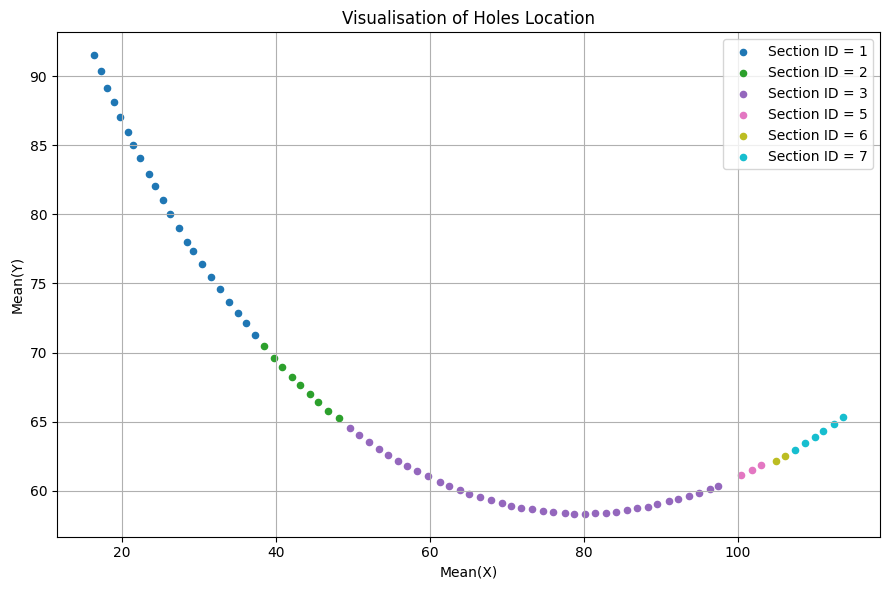

In [13]:
visualise_data(sub_data)

### Step 2: Define a NLL for each model (isotropic and central)

### Isostropic Model

In [14]:
import numpy as np
from iminuit import Minuit

def neg_log_likelihood_is(N, R, sigma,
                       phase_0, phase_1, phase_2, phase_3, phase_4, phase_5,
                       xcent_0, xcent_1, xcent_2, xcent_3, xcent_4, xcent_5,
                       ycent_0, ycent_1, ycent_2, ycent_3, ycent_4, ycent_5):
    """
    Compute the negative log-likelihood for 6 sections dynamically.

    Parameters:
    N, R, sigma_r, sigma_t : float
        Model parameters for ring radius and error standard deviations.
    phase_i, xcent_i, ycent_i : float
        Phase shifts and translations for each of the 6 sections.

    Returns:
    float
        Negative log-likelihood value (to be minimized by iminuit).
    """
    # Convert parameters into arrays to avoid shape issues
    phases = np.array([phase_0, phase_1, phase_2, phase_3, phase_4, phase_5])
    xcents = np.array([xcent_0, xcent_1, xcent_2, xcent_3, xcent_4, xcent_5])
    ycents = np.array([ycent_0, ycent_1, ycent_2, ycent_3, ycent_4, ycent_5])

    # Ensure data is a NumPy array before passing it
    global data
    data = np.array(data, dtype=object)  # Convert data list to a NumPy array (dtype=object keeps tuples)

    # Compute log-likelihood and negate it
    params = np.array([R, sigma, *phases, *xcents, *ycents])  # Convert to array to avoid issues
    return -log_likelihood_isotropic(params, data, N)  # Negate log-likelihood for minimization

# Example setup for 6 sections

num_sections = 6  # Now using 6 sections


data = [(sub_data['Mean(X)'], sub_data['Mean(Y)'])]


# Initial parameter estimates for 6 sections
N = 355
R_init = 77.0
sigma_init = 0.15
np.random.seed(1)
phases_init = np.random.uniform(-2.57, -2.51, 6)#[-2.53, -2.53, -2.53, -2.54, -2.55, -2.55]
xcents_init = np.random.uniform(78, 84, 6) #[79, 79, 79, 81, 81, 83]
ycents_init = np.random.uniform(134, 137, 6) # [136, 135, 135, 136, 135, 136]

# Combine parameters into one list
init_params = [N, R_init, sigma_init, *phases_init, *xcents_init, *ycents_init]

m_is = Minuit(neg_log_likelihood_is, 
           N=init_params[0], R=init_params[1], sigma=init_params[2],
           phase_0=init_params[3], phase_1=init_params[4], phase_2=init_params[5], 
           phase_3=init_params[6], phase_4=init_params[7], phase_5=init_params[8],
           xcent_0=init_params[9], xcent_1=init_params[10], xcent_2=init_params[11], 
           xcent_3=init_params[12], xcent_4=init_params[13], xcent_5=init_params[14],
           ycent_0=init_params[15], ycent_1=init_params[16], ycent_2=init_params[17], 
           ycent_3=init_params[18], ycent_4=init_params[19], ycent_5=init_params[20])

# Define likelihood optimization settings
m_is.errordef = Minuit.LIKELIHOOD
m_is.limits['N'] = (345, 365)  # Set realistic bounds for N
m_is.limits['R'] = (60, 80)
m_is.limits['sigma'] = (0, None)  # sigma must be positive


# Run the minimization
m_is.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.533                      │             Nfcn = 2352              │
│ EDM = 6.98e-05 (Goal: 0.0001)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N       │   354.7   │    2.9    │            │            │   345   │   365   │       │
│ 1 │ R       │   78.6    │    0.4    │            │            │   60    │   80    │       │
│ 2 │ sigma   │    2.0    │    0.7    │            │            │    0    │         │       │
│ 3 │ phase_0 │  -2.525   │   0.011   │            │            │         │         │       │
│ 4 │ phase_1 │   -2.5    │    1.0    │            │            │         │         │       │
│ 5 │ phase_2 │   -2.6    │    1.0    │            │            │         │         │       │
│ 6 │ phase_3 │   -2.6    │    1.0    │            │            │         │         │       │
│ 7 │ phase_4 │   -2.6    │    1.0    │            │            │         │         │       │
│ 8 │ phase_5 │   -2.6    │    1.0    │            │            │         │         │       │
│ 9 │ xcent_0 │   80.4    │    0.6    │            │            │         │         │       │
│ 10│ xcent_1 │   80.1    │    1.0    │            │            │         │         │       │
│ 11│ xcent_2 │   80.4    │    1.0    │            │            │         │         │       │
│ 12│ xcent_3 │   81.2    │    1.0    │            │            │         │         │       │
│ 13│ xcent_4 │   80.5    │    1.0    │            │            │         │         │       │
│ 14│ xcent_5 │   82.1    │    1.0    │            │            │         │         │       │
│ 15│ ycent_0 │   136.9   │    0.6    │            │            │         │         │       │
│ 16│ ycent_1 │   136.6   │    1.0    │            │            │         │         │       │
│ 17│ ycent_2 │   134.1   │    1.0    │            │            │         │         │       │
│ 18│ ycent_3 │    136    │     1     │            │            │         │         │       │
│ 19│ ycent_4 │   135.3   │    1.0    │            │            │         │         │       │
│ 20│ ycent_5 │   135.7   │    1.0    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│         │        N        R    sigma  phase_0  phase_1  phase_2  phase_3  phase_4  phase_5  xcent_0  xcent_1  xcent_2  xcent_3  xcent_4  xcent_5  ycent_0  ycent_1  ycent_2  ycent_3  ycent_4  ycent_5 │
├─────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│       N │     8.56     0.57      1.2 20.33e-3      0.0      0.0      0.0      0.0      0.0     0.08      0.0      0.0      0.0 

Collecting optimised parameters

In [15]:
N_opt_is = m_is.values["N"]  # Optimised number of holes
R_opt_is = m_is.values["R"]  # Optimised ring radius
sigma_opt_is = m_is.values["sigma"]  # Error

# Extract section-wise parameters into arrays
num_sections = 6  # Assuming 6 sections

phases_opt_is = np.array([m_is.values[f"phase_{i}"] for i in range(num_sections)])
xcents_opt_is = np.array([m_is.values[f"xcent_{i}"] for i in range(num_sections)])
ycents_opt_is = np.array([m_is.values[f"ycent_{i}"] for i in range(num_sections)])

# Store all extracted parameters in a structured array
optimised_params_is = np.array([phases_opt_is, xcents_opt_is, ycents_opt_is])


### Radial-Tangential model

In [16]:
import numpy as np
from iminuit import Minuit

def neg_log_likelihood_rt(N, R, sigma_r, sigma_t,
                       phase_0, phase_1, phase_2, phase_3, phase_4, phase_5,
                       xcent_0, xcent_1, xcent_2, xcent_3, xcent_4, xcent_5,
                       ycent_0, ycent_1, ycent_2, ycent_3, ycent_4, ycent_5):
    """
    Compute the negative log-likelihood for 6 sections dynamically.

    Parameters:

    N, R, sigma_r, sigma_t : float
        Model parameters for ring radius and error standard deviations.
    phase_i, xcent_i, ycent_i : float
        Phase shifts and translations for each of the 6 sections.

    Returns:
    float
        Negative log-likelihood value (to be minimized by iminuit).
    """
    # Convert parameters into arrays to avoid shape issues
    phases = np.array([phase_0, phase_1, phase_2, phase_3, phase_4, phase_5])
    xcents = np.array([xcent_0, xcent_1, xcent_2, xcent_3, xcent_4, xcent_5])
    ycents = np.array([ycent_0, ycent_1, ycent_2, ycent_3, ycent_4, ycent_5])

    # Ensure data is a NumPy array before passing it
    global data
    data = np.array(data, dtype=object)  # Convert data list to a NumPy array (dtype=object keeps tuples)

    # Compute log-likelihood and negate it
    params = np.array([R, sigma_r, sigma_t, *phases, *xcents, *ycents])  # Convert to array to avoid issues
    return -log_likelihood_rt(params, data, N)  # Negate log-likelihood for minimization

# Example setup for 6 sections

num_sections = 6  # Now using 6 sections


data = [(sub_data['Mean(X)'], sub_data['Mean(Y)'])]


# Initial parameter estimates for 6 sections
N = 355
R_init = 77
sigma_r_init = 0.04
sigma_t_init = 0.1
np.random.seed(1)
phases_init = np.random.uniform(-2.57, -2.51, 6)#[-2.53, -2.53, -2.53, -2.54, -2.55, -2.55]
xcents_init = np.random.uniform(78, 84, 6) #[79, 79, 79, 81, 81, 83]
ycents_init = np.random.uniform(134, 137, 6) # [136, 135, 135, 136, 135, 136]


# Combine parameters into one list
init_params = [N, R_init, sigma_r_init, sigma_t_init, *phases_init, *xcents_init, *ycents_init]

m_rt = Minuit(neg_log_likelihood_rt, 
           N=init_params[0], R=init_params[1], sigma_r=init_params[2], sigma_t=init_params[3],
           phase_0=init_params[4], phase_1=init_params[5], phase_2=init_params[6], 
           phase_3=init_params[7], phase_4=init_params[8], phase_5=init_params[9],
           xcent_0=init_params[10], xcent_1=init_params[11], xcent_2=init_params[12], 
           xcent_3=init_params[13], xcent_4=init_params[14], xcent_5=init_params[15],
           ycent_0=init_params[16], ycent_1=init_params[17], ycent_2=init_params[18], 
           ycent_3=init_params[19], ycent_4=init_params[20], ycent_5=init_params[21])

# Define likelihood optimization settings
m_rt.errordef = Minuit.LIKELIHOOD
m_rt.limits['N'] = (345, 365)  # Set realistic bounds for N
m_rt.limits['R'] = (60, 80)
m_rt.limits['sigma_r'] = (0, None)  # sigma_r must be positive
m_rt.limits['sigma_t'] = (0, None)  # sigma_t must be positive

# Run the minimization
m_rt.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.367                      │             Nfcn = 1952              │
│ EDM = 7.66e-05 (Goal: 0.0001)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N       │    354    │     4     │            │            │   345   │   365   │       │
│ 1 │ R       │   78.3    │    0.8    │            │            │   60    │   80    │       │
│ 2 │ sigma_r │   0.96    │   0.07    │            │            │    0    │         │       │
│ 3 │ sigma_t │   2.15    │   0.15    │            │            │    0    │         │       │
│ 4 │ phase_0 │  -2.529   │   0.011   │            │            │         │         │       │
│ 5 │ phase_1 │   -2.5    │    1.0    │            │            │         │         │       │
│ 6 │ phase_2 │   -2.6    │    1.0    │            │            │         │         │       │
│ 7 │ phase_3 │   -2.6    │    1.0    │            │            │         │         │       │
│ 8 │ phase_4 │   -2.6    │    1.0    │            │            │         │         │       │
│ 9 │ phase_5 │   -2.6    │    1.0    │            │            │         │         │       │
│ 10│ xcent_0 │   80.43   │   0.23    │            │            │         │         │       │
│ 11│ xcent_1 │   80.1    │    1.0    │            │            │         │         │       │
│ 12│ xcent_2 │   80.4    │    1.0    │            │            │         │         │       │
│ 13│ xcent_3 │   81.2    │    1.0    │            │            │         │         │       │
│ 14│ xcent_4 │   80.5    │    1.0    │            │            │         │         │       │
│ 15│ xcent_5 │   82.1    │    1.0    │            │            │         │         │       │
│ 16│ ycent_0 │   136.6   │    0.9    │            │            │         │         │       │
│ 17│ ycent_1 │   136.6   │    1.0    │            │            │         │         │       │
│ 18│ ycent_2 │   134.1   │    1.0    │            │            │         │         │       │
│ 19│ ycent_3 │    136    │     1     │            │            │         │         │       │
│ 20│ ycent_4 │   135.3   │    1.0    │            │            │         │         │       │
│ 21│ ycent_5 │   135.7   │    1.0    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│         │        N        R  sigma_r  sigma_t  phase_0  phase_1  phase_2  phase_3  phase_4  phase_5  xcent_0  xcent_1  xcent_2  xcent_3  xcent_4  xcent_5  ycent_0  ycent_1  ycent_2  ycent_3  ycent_4  ycent_5 │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│       

Collecting optimised parameters

In [17]:
N_opt_rt = m_rt.values["N"]  # Optimised number of holes
R_opt_rt = m_rt.values["R"]  # Optimised ring radius
sigma_r_opt_rt = m_rt.values["sigma_r"]  # Radial error
sigma_t_opt_rt = m_rt.values["sigma_t"]  # Tangential error

# Extract section-wise parameters into arrays
num_sections = 6  # Assuming 6 sections

phases_opt_rt = np.array([m_rt.values[f"phase_{i}"] for i in range(num_sections)])
xcents_opt_rt = np.array([m_rt.values[f"xcent_{i}"] for i in range(num_sections)])
ycents_opt_rt = np.array([m_rt.values[f"ycent_{i}"] for i in range(num_sections)])

# Store all extracted parameters in a structured array
optimised_params_rt = np.array([phases_opt_rt, xcents_opt_rt, ycents_opt_rt])



### Visualising Predicted vs Measured.

Now that we have determined the parameters estimates using the MLE method, we can now code up a function to display models predictions on a plot for each section, and compare the perdicted hole location to the measured location. 

Recall the following assumpiotns: 
- Unknown cercle-centres for each arc: $\vec{r}_{0j} = (x_{0j}, y_{0j})$, for $j \in [0, s-1]$ where $s$ is the number of sections.
- $j^{\text{th}}$ section, $\alpha_j$ is the angular position of the first hole of the full circle.
- $\phi_{ij}$ is the apparent position for the $i^{\text{th}}$ hole in the $j^{\text{th}}$ section:
  $$
  \phi_{ij} = 2\pi \frac{(i-1)}{N} + \alpha_j
  $$
- Three unknown paramters ($x_{0j}, y_{0j}, \alpha_j$), defining displacement and roatation.

Hence the predifcted holes location can be modelled as follow:

$$
x_{ij} = R \cos{\phi_{ij}} + x_{0j}
$$#
$$
y_{ij} = R \sin{\phi_{ij}} + y_{0j}
$$


In [18]:
# Converting Section ID into array format using .to_numpy()
sec_id_sub = sub_data['Section ID'].to_numpy()
print('Section ID before adaptation to new format:')
print(sec_id_sub)

print('')

'''  
For our likelihood models we have labeled sections from 0 to 5, but the observed data is 
registered with section id from 1 to 7, exluding sections 0 and 4. 

The objective is to relabel the Section ID from 0 to 5, by subtracting 1 when elements in Section ID
are less than 4, and subtract 2 otherwise.

'''

sec_mod = jnp.array([x-1 if x < 4 else x - 2 for x in sec_id_sub]) 
print('Section ID adapted to new format:')
print(sec_mod)

Section ID before adaptation to new format:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 6 6 7
 7 7 7 7 7]

Section ID adapted to new format:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 4 4 5
 5 5 5 5 5]


<b>Computing the predicted hole location for each model</b>

In [19]:
# Computing hole predicted location using predicted parameters from Iminuit for:

# Radial-Tangential Model:
predicted_hole_loc_rt = hole_prediction(N_opt_rt, R_opt_rt, optimised_params_rt, sec_mod)

# Isotropic Model:
predicted_hole_loc_is = hole_prediction(N_opt_is, R_opt_is, optimised_params_is, sec_mod)


As we have now computed the predicted hole location for each model, we now aim to collect everything into a data-frame format, using `pandas`, `pred_data_rt` for radial-tangential model and `pred_data_is` for the isotropic model, to match the measured data `sub_data` format. And then one can plot the predicted data vs measured data.

In [20]:
# Constructiong Data Frame for:

# Radial-Tangential Model

d_rt_MLE = {

    'Section ID' : sub_data['Section ID'].to_numpy(),
    'Hole' : sub_data['Hole'].to_numpy(),
    'Mean(X)' : predicted_hole_loc_rt[0],
    'Mean(Y)' : predicted_hole_loc_rt[1]
}

pred_data_rt_MLE = pd.DataFrame(d_rt_MLE)

# Isotropic Model

d_is_MLE = {

    'Section ID' : sub_data['Section ID'].to_numpy(),
    'Hole' : sub_data['Hole'].to_numpy(),
    'Mean(X)' : predicted_hole_loc_is[0],
    'Mean(Y)' : predicted_hole_loc_is[1]
}

pred_data_is_MLE = pd.DataFrame(d_is_MLE)


### Plot comparisons

<b>Isotropic Model Prediction vs Measured Data</b>

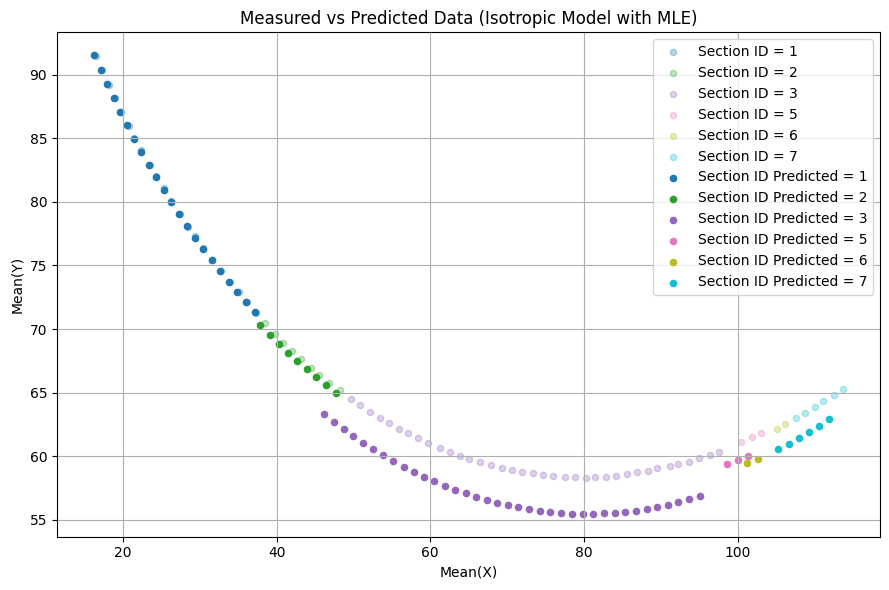

In [21]:
plotting_comparison(sub_data, pred_data_is_MLE, 'Isotropic Model with MLE')

<b>Radial-Tangential Model Prediction vs Measured Data</b>

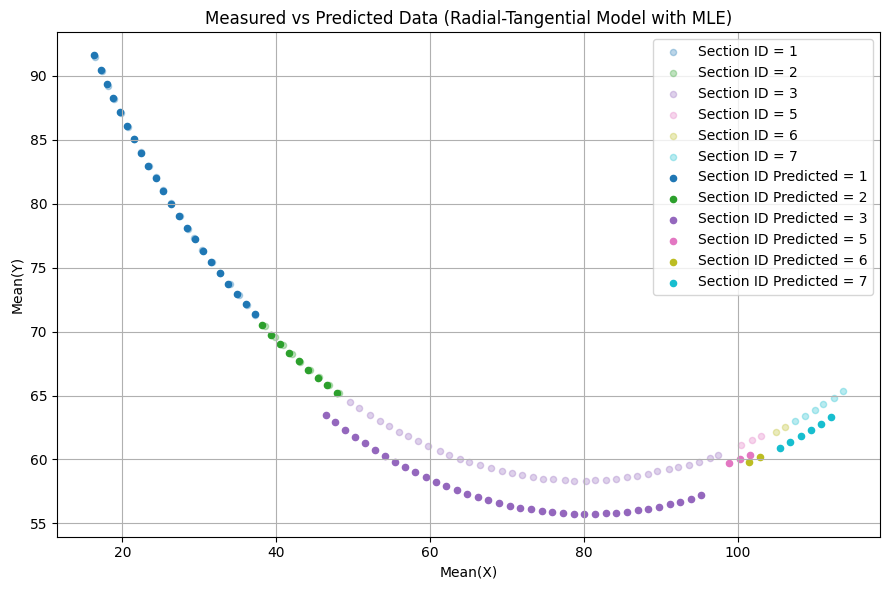

In [22]:
plotting_comparison(sub_data, pred_data_rt_MLE, 'Radial-Tangential Model with MLE')

## Todo 

- Justify why MLE is not the best method for this particular datase, i.e. to many parmeters for only few data points (21/22 parm vs 79 datapoints)

### Part (f) HMC



In [23]:
hole_d, x_d, y_d = jnp.array(sub_data['Hole'].to_numpy()), jnp.array(sub_data['Mean(X)'].to_numpy()), jnp.array(sub_data['Mean(Y)'].to_numpy())

In [24]:
nuts_kernel_rt = NUTS(rad_tang_model)

mcmc_rt = MCMC(nuts_kernel_rt, num_samples=2000, num_warmup=1000)
rng_key = jax.random.key(0)
mcmc_rt.run(rng_key, sec_mod, hole_d, x_obs = x_d, y_obs = y_d)

posterior_samples_rt = mcmc_rt.get_samples()

  0%|          | 0/3000 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
N_rt_pred_HMC = jnp.mean(posterior_samples_rt['N'])
R_rt_pred_HMC = jnp.mean(posterior_samples_rt['r'])

num_sections = 6  # Assuming 6 sections

phases_opt_rt_HMC = jnp.mean(posterior_samples_rt["alpha_pred"], axis=0)
xcents_opt_rt_HMC = jnp.mean(posterior_samples_rt["x_centre"], axis=0)
ycents_opt_rt_HMC = jnp.mean(posterior_samples_rt["y_centre"], axis=0)

# Store all extracted parameters in a structured array
optimised_params_rt_HMC = jnp.array([phases_opt_rt_HMC, xcents_opt_rt_HMC, ycents_opt_rt_HMC])

In [ ]:
mcmc_rt.print_summary()

In [ ]:
nuts_kernel = NUTS(isotropic_model)

mcmc_iso = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000)
rng_key_iso = jax.random.key(0)
mcmc_iso.run(rng_key_iso, sec_mod, hole_d, x_obs = x_d, y_obs = y_d)

posterior_samples_iso = mcmc_iso.get_samples()

In [ ]:
N_is_pred_HMC = jnp.mean(posterior_samples_iso['N'])
R_is_pred_HMC = jnp.mean(posterior_samples_iso['r'])

num_sections = 6  # Assuming 6 sections

phases_opt_iso_HMC = jnp.mean(posterior_samples_iso["alpha_pred"], axis=0)
xcents_opt_iso_HMC = jnp.mean(posterior_samples_iso["x_centre"], axis=0)
ycents_opt_iso_HMC = jnp.mean(posterior_samples_iso["y_centre"], axis=0)

# Store all extracted parameters in a structured array
optimised_params_iso = jnp.array([phases_opt_iso_HMC, xcents_opt_iso_HMC, ycents_opt_iso_HMC])

In [ ]:
mcmc_iso.print_summary()

In [ ]:
# Computing hole predicted location using predicted parameters from Iminuit for:

# Radial-Tangential Model:
predicted_hole_loc_rt_HMC = hole_prediction(N_rt_pred_HMC, R_rt_pred_HMC, optimised_params_rt_HMC, sec_mod)

# Isotropic Model:
predicted_hole_loc_is_HMC = hole_prediction(N_is_pred_HMC, R_is_pred_HMC, optimised_params_iso, sec_mod)

# Constructiong Data Frame for:

# Radial-Tangential Model HMC

d_rt_HMC = {

    'Section ID' : sub_data['Section ID'].to_numpy(),
    'Hole' : sub_data['Hole'].to_numpy(),
    'Mean(X)' : predicted_hole_loc_rt_HMC[0],
    'Mean(Y)' : predicted_hole_loc_rt_HMC[1]
}

pred_data_rt_HMC = pd.DataFrame(d_rt_HMC)

# Radial-Tangential Model HMC

d_is_HMC = {

    'Section ID' : sub_data['Section ID'].to_numpy(),
    'Hole' : sub_data['Hole'].to_numpy(),
    'Mean(X)' : predicted_hole_loc_is_HMC[0],
    'Mean(Y)' : predicted_hole_loc_is_HMC[1]
}

pred_data_is_HMC = pd.DataFrame(d_is_HMC)


Visualisation of predicted holes location vs true holes location, for the HMC algorithm.

In [ ]:
plotting_comparison(sub_data, pred_data_rt_HMC, 'Radial-Tangential Model with HMC')
plotting_comparison(sub_data, pred_data_is_HMC, 'Isotropic Model with HMC')

Corner plots using `corner`.

Plotting corner plots of predicted parameter distribution for both isotropic and radial-tangential models. Both plots display the uncertainty for each parameter prediction, as well as the confidence interval with quantiles $(0.15, 0.5, 0.85)$. 

(Please check `plotting.py`, where the we defined the function for corner plotting)

In [ ]:

corner_plots(posterior_samples_iso, posterior_samples_rt) # Input required: sampled posteriors from our HMC for both models

Pick one of the holes, on your plot
of the measured hole locations, show the posterior predictive distribution for its hole
locations using both models. (NEED TO FINISH PART (f)) 

<b>Posterior Predictive Distribution for a Hole</b>

For this part we want to determine the posterior predictive distribution of a single hole. The way one can do this, is to implement a dynamic code, allowing the reader to choose a specific hole by selecting index value, i.e. outputs are reproducible for every hole.

<b>Theory</b>
-	How to determine posterior predictive distribution:

    Let us recall posterior predictive distribution from the lectures,

    $$
    p(\tilde{x}|D) = \int \mathcal{L}(\tilde{x}|\theta)P(\theta|D)d\theta
    $$

    EXPLAIN WHAT EACH THING IS

<b>Procedure</b>

-	Find posterior predictive samples for both Isotropic and Radial-Tangential Models:

    This can be achieved using the module `Predictive` from `numpyro.infer` (this will be computed in the following Python cell).

-	From predictive samples, draw the posterior predictive distributions for a single hole:

    Once we determine the predictive samples for both models, all we must do is to draw the distribution for a single hole. There is a function in `plotting.py`,  `joint_plot_sns`, this will take as input predicted samples, hole index, original data (in `DataFrame` format), and title choice, outputting a 2D joint plot of points $(x,y)$, with the addition of marginal distributions.




In [ ]:
# Generate posterior predictive samples (radial-tangential model)
predictive_rt = Predictive(rad_tang_model, posterior_samples=posterior_samples_rt)
posterior_predictive_samples_rt = predictive_rt(jax.random.key(1), sec_mod, hole_d)

# Generate posterior predictive samples (isotropic model)
predictive_is = Predictive(isotropic_model, posterior_samples_iso)
posterior_predictive_samples_is = predictive_is(jax.random.key(1), sec_mod, hole_d)

Check shape output:

In [ ]:
post_pred_sample_hole_rt = posterior_predictive_samples_rt['obs']
post_pred_sample_hole_is = posterior_predictive_samples_is['obs']
print('Shape posterior predictive sample generated from posterior samples generated from:')
print('- Radial tangential model,', post_pred_sample_hole_rt.shape)
print('- Isotropic model,', post_pred_sample_hole_is.shape)

Visualising Posteriro Predictive Distribution

In [ ]:
# Set hole index
hole_index = 12
joint_plot_sns(post_pred_sample_hole_rt, hole_index, sub_data, 'Radial-Tangential Model')
joint_plot_sns(post_pred_sample_hole_is, hole_index, sub_data, 'Isotropic Model')

### Part (g)

Essentially the above is a model comparison question - and in Bayesian inference, one can perform model comparison by determining the evidence, (also called the marginal likelihood).

Recall evidence:

$$
Z = \int \mathcal{L}(D|\theta)\pi(\theta)d\theta
$$

Conditions for preferred model:
-	If $Z_{rt} >> Z_{iso}$ then the data clearly favour the radial-tangential model.
-	Otherwise, data favour isotropic model

Once determined the evidence of both models, one can compute the Bayesian Factor (BF) as follows:
$$
BF = \frac{ Z_{rt} }{ Z_{iso}}
$$
Or, more commonly (and more numerically stable), use the log-evidence:
$$
\log{BF} = \log{Z_{rt}} - \log{Z_{is}}
$$

And interpret using Jeffreys’ scale!

 | $\log{BF}$ (log-evidence difference) | Strenght of evidence for Radial-Tangential and Isotropic Models|
 |--------------------------------------|----------------------------------------------------------------|
 |$<1$| Not worth more than a bare mention|
 |$[1, 2.5]$| Substantial|
 |$[2.5, 5]$| Strong |
 |$>5$| Decisive|


⚠ Note, one can argue that, finding the evidence is not necessary for our project if we can show the following:
-	The radial-tangential model has much tighter posteriors for key parameters (e.g. $N$).
-	The predictive plots under radial-tangential model fit the data better than isotropic model.
-	The physical reasoning behind radial vs tangential errors, rather than isotropic error, makes more sense

This is exactly what Woan & Bayley presented in Ref[[2](https://github.com/MatteoMancini01/S2_Cw/blob/main/relevant_material/2403.00040v1.pdf)], where they mention that without modelling anisotropic error, the uncertainty in $N$ is three times higher, and that’s enough to show the radial-tangential model is better supported.

Although providing a few lines of codes to determine the evidence of each model would hurt, strengthening our final conclusion based on what we have seen so far! 

<b>Nested Sampling</b>

To tackle this task, we are going to rely on Nested Sampling Algorithm. In the Python file `original_model.py` there are two functions `prior_transform_isotropic` and `prior_transform_rt` (for Isotropic and Radial-Tangential Models respectively), designed to serve as inputs for our Nested Sampling Algorithm. To execute the algorithm, one can us the module `NestedSampler` and its features from the Python package [`dynasty`](https://dynesty.readthedocs.io/en/stable/). 

From `original_model.py`, we have already deifned a log-likelihood function for each model, and as already mentioned the appropriate priors. So fare we have presented the Antikythera Mechanism observed data in `pandas.DataFrame` format, which is not compatible with the defined log-likelihood functions, hence we need to collect the available data into a [[`array[]`, `array[]`], [`array[]`, `array[]`], ..., [`array[]`, `array[]`]] format.

In [ ]:
# Prepare data

# Create list of (x, y) tuples, one per section
data_for_NS = []
for sec_id in sorted(sub_data['Section ID'].unique()):
    section_df = sub_data[sub_data['Section ID'] == sec_id]
    x = section_df['Mean(X)'].to_numpy()
    y = section_df['Mean(Y)'].to_numpy()
    data_for_NS.append((x, y))

Now we want to define `loglike` functions to feed to `NestedSampler`

In [ ]:
# Log-Like for Radial-Tangential
def loglike_rt(theta):
    return log_likelihood_rt(theta, data_for_NS, int(N_rt_pred_HMC)) # setting output from HMC to integer (speeds up the process)

# Log-Like for Isotropic
def loglike_iso(theta):
    return log_likelihood_isotropic(theta, data_for_NS, int(N_is_pred_HMC))

Ready to use `NestedSampler`!

In [ ]:
# Nested Sample Algorithm for Radial-Tangential
sampler_rt = NestedSampler(loglike_rt, prior_transform_rt, ndim=21, nlive=10000, sample='rwalk', bound='multi')
sampler_rt.run_nested()

In [ ]:
from dynesty.utils import resample_equal
import numpy as np

results = sampler_rt.results
samples = results.samples               # shape (n_samples, ndim)
weights = np.exp(results.logwt - results.logz[-1])

# Resample to get equally-weighted posterior samples
posterior_samples = resample_equal(samples, weights)


In [ ]:
r_samples       = posterior_samples[:, 0]
sigma_r_samples = posterior_samples[:, 1]
sigma_t_samples = posterior_samples[:, 2]

# Optional: get section-specific parameters
phase_samples = posterior_samples[:, 3:9]      # shape: (n_samples, 6)
x_center_samples = posterior_samples[:, 9:15]
y_center_samples = posterior_samples[:, 15:21]


In [ ]:
# Nested Sample Algorithm for Isotropic
sampler_iso = NestedSampler(loglike_iso, prior_transform_isotropic, ndim=20, nlive=1000, sample='rwalk', bound='multi')
sampler_iso.run_nested()

Result and Interpretation

In [ ]:
# Collecting log-evidence from:

# Radial-Tangential
result_rt = sampler_rt.results
logZ_rt = result_rt.logz[-1]

# Isotropic
result_iso = sampler_iso.results
logZ_iso = result_iso.logz[-1]

print(f"Log Evidence (Radia-Tangential Model): {logZ_rt:.2f}")
print(f"Log Evidence (Isotropic Model): {logZ_iso:.2f}")

Determining $\log{BF}$ \& interpretation

In [ ]:
logBF = logZ_rt - logZ_iso

print(f'The log-evidence difference is {logBF}, this suggests that:')
print('')
if logBF < 1:
    print('The evidentice is essentially the same, i.e. neither model is clearly better')
elif 1<=logBF<2.5:
    print('''The evidence from Radial-Tangential model is substantially supported,
          this model is prefered, but we need to be cautious, as this is not conlusive''')
elif 2.5<=logBF<5:
    print('''The evidence from Radial-Tangential model is strongly supported, it is quite safe to favour the this model''')
else:
    print('''The evidence from Radial-Tangential model is decisive, we can confidently select the Radial-Tangential model
          over the Isotropic model''')